> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

We will be accessing files on S3 in this notebook. Since those files are public, we set the `AWS_NO_SIGN_REQUEST` to tell `rasterio` to skip the sign-in.

In [1]:
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


# Prediction and Evaluation

In [2]:
bundle_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip'

In [3]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

INFO:matplotlib.font_manager:generated new fontManager
2024-08-07 14:02:43:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip.
INFO:rastervision.pytorch_learner.learner:Loading learner from bundle s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2024-08-07 14:02:43:rastervision.pipeline.file_system.utils: INFO - Downloading s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip to /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip...
INFO:rastervision.pipeline.file_system.utils:Downloading s3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/train/model-bundle.zip to /opt/d

Downloading:  67%|######7   | 189M/281M [00:05<00:02, 39.6MB/s]

2024-08-07 14:02:52:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpfkl0s9yt/model-bundle
INFO:rastervision.pytorch_learner.learner:Unzipping model-bundle to /opt/data/tmp/tmpfkl0s9yt/model-bundle
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 42.4MB/s]
2024-08-07 14:02:57:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpfkl0s9yt/model-bundle/model.pth
INFO:rastervision.pytorch_learner.learner:Loading model weights from: /opt/data/tmp/tmpfkl0s9yt/model-bundle/model.pth


## Get scene to predict

In [4]:
scene_id = 5631
image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

In [10]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['building', 'background'], 
    colors=['orange', 'black'], 
    null_class='background',
)
class_config.ensure_null_class()

Load stats that will be used to normalize the images before they are fed into the model:

In [7]:
from rastervision.core.data import StatsTransformer

stats_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.31/spacenet-vegas-buildings-ss/analyze/stats/train_scenes/stats.json'
stats_tf = StatsTransformer.from_stats_json(stats_uri)
stats_tf

StatsTransformer(means=array([424.87790094, 592.92457995, 447.27932498]), stds=array([220.60852518, 242.79340345, 148.50591309]), max_stds=3.0)

In [11]:
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

import albumentations as A

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    image_raster_source_kw=dict(raster_transformers=[stats_tf]),
    size=325,
    stride=325,
    out_size=325,
)

2024-08-07 14:03:51:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5631.tif.
INFO:rastervision.pipeline.file_system.utils:Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5631.tif.


In [12]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(325, 325)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config))

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

## Visualize predictions

In [13]:
scores = pred_labels.get_score_arr(pred_labels.extent)

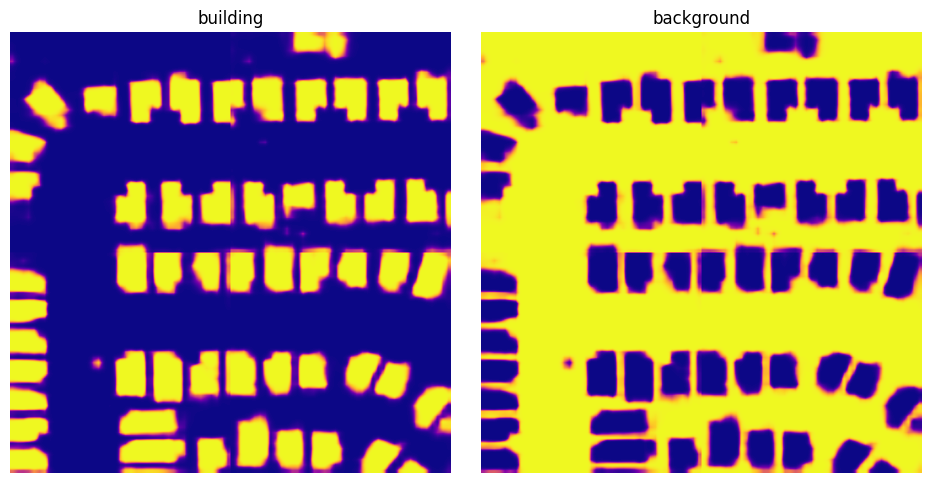

In [14]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [15]:
pred_labels.save(
    uri=f'data/spacenet-vegas-buildings-ss/predict/{scene_id}',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config)

Saving pixel labels:   0%|          | 0/2 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate predictions

In [16]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

2024-08-07 14:04:09:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5631.geojson.
INFO:rastervision.pipeline.file_system.utils:Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5631.geojson.


In [17]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Evaluation for the building class:

In [18]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'building',
 'conf_mat': [[288879.0, 12375.0], [9244.0, 112002.0]],
 'conf_mat_dict': {'FN': 9244.0, 'FP': 12375.0, 'TN': 288879.0, 'TP': 112002.0},
 'conf_mat_frac': [[0.6837372781065089, 0.029289940828402368],
                   [0.0218792899408284, 0.26509349112426034]],
 'conf_mat_frac_dict': {'FN': 0.0218792899408284,
                        'FP': 0.029289940828402368,
                        'TN': 0.6837372781065089,
                        'TP': 0.26509349112426034},
 'count_error': 3131.0,
 'gt_count': 121246.0,
 'metrics': {'f1': 0.9119829983348464,
             'precision': 0.9005041124966835,
             'recall': 0.9237583095524801,
             'sensitivity': 0.9237583095524801,
             'specificity': 0.958921707263638},
 'pred_count': 124377.0,
 'relative_frequency': 0.2869727810650888}

Evaluation for the background class:

In [19]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'background',
 'conf_mat': [[112002.0, 9244.0], [12375.0, 288879.0]],
 'conf_mat_dict': {'FN': 12375.0, 'FP': 9244.0, 'TN': 112002.0, 'TP': 288879.0},
 'conf_mat_frac': [[0.26509349112426034, 0.0218792899408284],
                   [0.029289940828402368, 0.6837372781065089]],
 'conf_mat_frac_dict': {'FN': 0.029289940828402368,
                        'FP': 0.0218792899408284,
                        'TN': 0.26509349112426034,
                        'TP': 0.6837372781065089},
 'count_error': 3131.0,
 'gt_count': 301254.0,
 'metrics': {'f1': 0.9639308815653587,
             'precision': 0.9689926641017298,
             'recall': 0.958921707263638,
             'sensitivity': 0.958921707263638,
             'specificity': 0.9237583095524801},
 'pred_count': 298123.0,
 'relative_frequency': 0.7130272189349113}

### Save evaluation

In [20]:
evaluation.save(f'data/eval-{scene_id}.json')